# Notebook to evaluate cardinals

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import pandas as pd
from numpy import int16
from pathlib import Path
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from napari_segmentation_overlap_filter.functions import create_overlap_df, overlapping_objects, return_overlap_segmentation, return_non_zero_pixels_from_Image, get_object_sizes, timer_func

from glob import glob
from tqdm import tqdm
from tifffile import imread

from skimage.segmentation import clear_border

import seaborn as sns
from collections import Counter
from timeit import default_timer as time

np.random.seed(42)

Hi Todd


## Functions

In [2]:
def matching3D(ground_truth_labels, segmentation_labels, threshold):
    #create the data frame and do the thresholding
    SegCompare_df = seg_compare_df(ground_truth_labels, segmentation_labels)
    SegCompare_df_thresh= SegCompare_df[SegCompare_df['Ground_Truth_Overlap_PCT']>threshold]
    SegCompare_df_thresh= SegCompare_df_thresh[SegCompare_df_thresh['Segmentation_Labels_Overlap_PCT']>threshold]
    
    #get a list of all the labels
    ground_truth_labels_list = list(np.unique(ground_truth_labels))
    segmentation_labels_list = list(np.unique(segmentation_labels))
    ground_truth_labels_list = [x for x in ground_truth_labels_list if x >= 1]
    segmentation_labels_list = [x for x in segmentation_labels_list if x >= 1]
    #get a list of the thresholded labels, and make sure they don't have the background as a label
    segmentation_labels_matched = list(SegCompare_df_thresh['Segmentation_Labels_Object_ID'])
    ground_truth_labels_matched = list(SegCompare_df_thresh['Ground_Truth_Object_ID'])
    ground_truth_labels_matched = [x for x in ground_truth_labels_matched if x >= 1]
    segmentation_labels_matched = [x for x in segmentation_labels_matched if x >= 1]
    
    
    # find out the true positives, i.e. the number of segmentation labels that are unique and matched a ground truth
    tp_list = list(np.unique(SegCompare_df_thresh['Segmentation_Labels_Object_ID']))
    
    # find out the false positives, the number of segmentation labels that exist but don't match a ground truth
    false_positive_list = [x for x in segmentation_labels_list if x not in segmentation_labels_matched]
    
    #find out the false negatives, the number of ground truth labels that exist, but didn't match a seg label
    false_negative_list = [x for x in ground_truth_labels_list if x not in ground_truth_labels_matched]
    
    tp = len(np.unique(tp_list))
    fp = len(np.unique(false_positive_list))
    fn = len(np.unique(false_negative_list))
    
    return tp, fp, fn, tp_list, false_positive_list, false_negative_list

In [3]:
# modified version of `create_overlap_df` to rename images

def seg_compare_df(ground_truth_labels, segmentation_labels):
    """
    creates a dataframe of all overlapping objects in each image, with object size and percentage of overlap
    :param Img_A: ground truth labels
    :param Img_B: segmentation labels
    :return: pd.dataframe
    """
    Img_A = ground_truth_labels
    Img_B = segmentation_labels
    objects_zip = overlapping_objects(Img_A, Img_B) #this is ordered so the objects will correspond
    
    objects_overlap_count = Counter(objects_zip)
    objects_set = objects_overlap_count.keys()
    objects_overlap_size = objects_overlap_count.values()
    
    A_objects = [ls[0] for ls in objects_set]
    B_objects = [ls[1] for ls in objects_set]
    
    A_overlap_size = list(objects_overlap_size)
    B_overlap_size = list(objects_overlap_size)
    
    A_obj_dict = get_object_sizes(Img_A, A_objects)
    B_obj_dict = get_object_sizes(Img_B, B_objects)
    
    Obj_A_size = []
    for obj in A_objects:
        Obj_A_size.append(A_obj_dict[obj])
    
    Obj_B_size = []
    for obj in B_objects:
        Obj_B_size.append(B_obj_dict[obj])    
    
    Overlap_Index = [n for n in np.arange(len(A_objects))]  # create overlap index
    
    data = {'Overlap_Index': Overlap_Index, 
       'Ground_Truth_Object_ID': A_objects,
       'Segmentation_Labels_Object_ID': B_objects,
       'Ground_Truth_Object_Size': Obj_A_size,
       'Segmentation_Labels_Object_Size': Obj_B_size,
       'Ground_Truth_Overlap_Size': A_overlap_size,
       'Segmentation_Labels_Overlap_Size': B_overlap_size}

    df = pd.DataFrame(data)
    assert(list(df['Ground_Truth_Overlap_Size'])==list(df['Segmentation_Labels_Overlap_Size'])) ## these should be identical
    df['Ground_Truth_Overlap_PCT'] = df['Ground_Truth_Overlap_Size']/df['Ground_Truth_Object_Size']
    df['Segmentation_Labels_Overlap_PCT'] = df['Segmentation_Labels_Overlap_Size']/df['Segmentation_Labels_Object_Size']
    
    return df

In [4]:
def matching_stats(tp, fp, fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = tp/(tp+fp+fn)
    f1 = (2*tp)/((2*tp)+fp+fn)
    
    return precision, recall, accuracy, f1

In [5]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def get_metrics(ground_truth, parseg, thresholds):
    tps = []
    fps = []
    fns = []
    precisions = []
    recalls = []
    accuracys = []
    f1s = []
    
    for threshold in thresholds:
        tp, fp, fn, tp_list, false_positive_list, false_negative_list = matching3D(ground_truth, parseg, threshold)
        tps.append(tp)
        fps.append(fp)
        fns.append(fn)
        precision, recall, accuracy, f1  = matching_stats(tp, fp, fn)
        precisions.append(precision)
        recalls.append(recall)
        accuracys.append(accuracy)
        f1s.append(f1)
    
    # Convert the data into a pandas DataFrame
    df = pd.DataFrame({
            'Precision': precisions,
            'Recall': recalls,
            'Accuracy': accuracys,
            'F1': f1s, 
            'Threshold': thresholds,
            'FP': fps,
            'TP': tps,
            'FN': fns,
        })
    return df

def plot_metrics(df, filename):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))
        
    for m in ('Precision', 'Recall', 'Accuracy', 'F1'):
        ax1.plot(thresholds, df[m], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()
        
    for m in ('FP', 'TP', 'FN'):
        ax2.plot(thresholds, df[m], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend()

    fig.suptitle(filename, fontsize=12)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

## Get metrics for whole dataset

In [6]:
def func(gt_path, pred_path, gt_pattern, pred_pattern, specified_thresholds):
    ground_truth_labels = sorted([item for item in gt_path.glob(gt_pattern)])
    parseg_labels = sorted([item for item in pred_path.glob(pred_pattern)])
    
    if len(ground_truth_labels) != len(parseg_labels):
        raise ValueError('Different number of labels')
    
    PRECISIONS = []
    RECALLS = []
    ACCURACYS = []
    F1S = []
    
    
    for specified_threshold in specified_thresholds:
    
        all_fps = []
        all_tps = []
        all_fns = []

        all_precisions = []
        all_recalls = []
        all_accuracys = []
        all_f1s = []

        for i in np.arange(len(ground_truth_labels)):
            gt_labels = imread(ground_truth_labels[i]).astype(np.int16)
            p_labels = imread(parseg_labels[i]).astype(np.int16)

            df = get_metrics(gt_labels, p_labels, thresholds)

            target_columns = ['Precision', 'Recall', 'Accuracy', 'F1', 'FP', 'TP', 'FN']
            all_metrics = [all_precisions, all_recalls, all_accuracys, all_f1s, all_fps, all_tps, all_fns]

            for j in np.arange(len(target_columns)):
                value = df.loc[df['Threshold'] == specified_threshold, target_columns[j]].values[0]
                all_metrics[j].append(value)
        
        total_fp = np.sum(all_fps)
        total_tp = np.sum(all_tps)
        total_fn = np.sum(all_fns)
        whole_precision, whole_recall, whole_accuracy, whole_f1 = matching_stats(total_tp, total_fp, total_fn)
        
        PRECISIONS.append(whole_precision)
        RECALLS.append(whole_recall)
        ACCURACYS.append(whole_accuracy)
        F1S.append(whole_f1)
    
    return PRECISIONS, RECALLS, ACCURACYS, F1S

In [7]:
ground_truth_label_dir = Path('/nemo/stp/lm/working/shared/vd_tf/Training_Data/Masks')
parseg_label_dir = Path('/nemo/stp/lm/working/shared/vd_tf/Training_Data/Images/results_refined')

# specify pattern matching rules if necessary
ground_truth_label_pattern = 'C3*'
parseg_label_pattern = 'LblImg_' + ground_truth_label_pattern + '.tif'

In [8]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [9]:
precision_combined, recall_combined, accuracy_combined, F1_combined = func(ground_truth_label_dir, parseg_label_dir, ground_truth_label_pattern, parseg_label_pattern, thresholds)

In [10]:
F1_combined

[0.8703543647363872,
 0.7844178840194777,
 0.7272727272727273,
 0.6740380362671384,
 0.5997357992073976,
 0.48348745046235136,
 0.34610303830911493,
 0.16468516072214884,
 0.02025539409951563]

#### Plot overall dataset metrics for PARSEG over tau

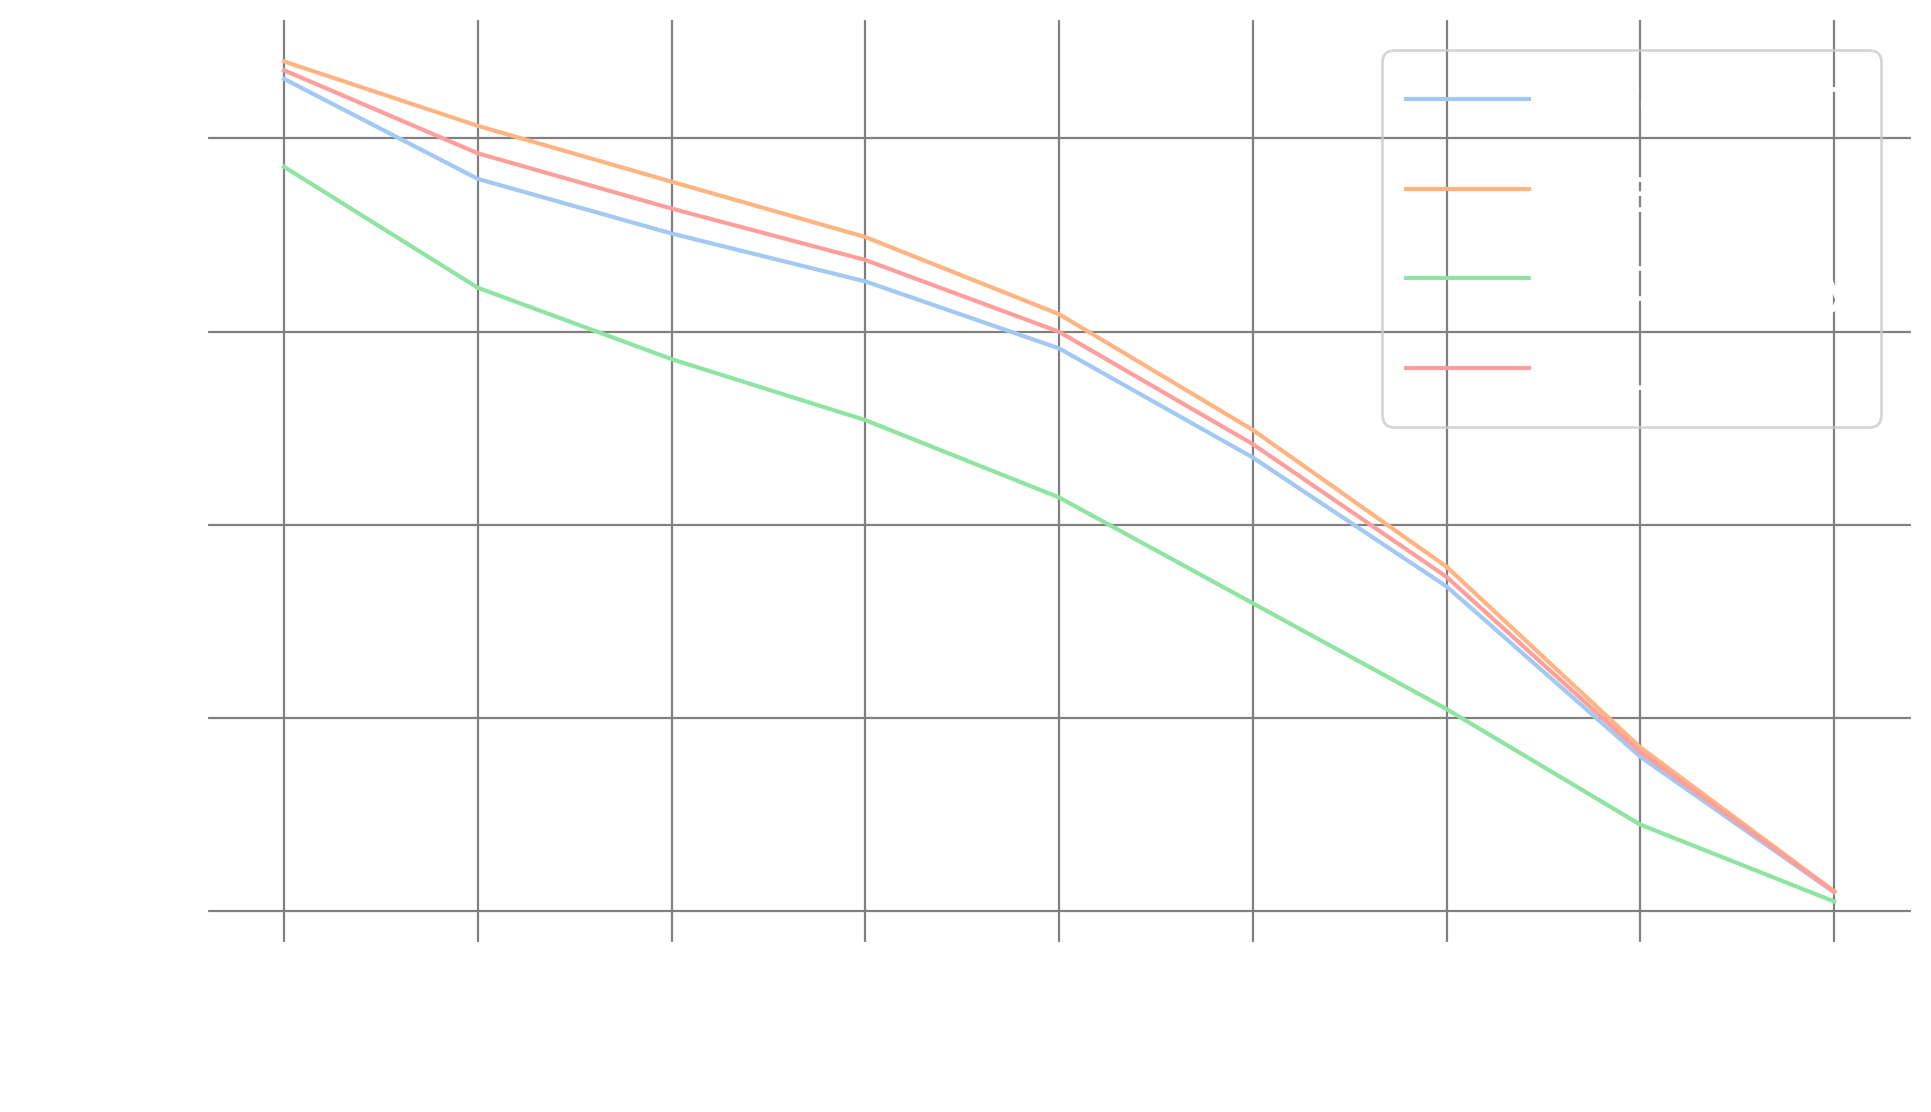

In [11]:
# Create a custom style
plt.style.use('dark_background')

# Customize the rcParams for a transparent or black background with white text
plt.rcParams.update({
    'axes.facecolor': 'none',     # Background color of the plot area
    'figure.facecolor': 'none',   # Background color around the plot
    'axes.edgecolor': 'white',     # Color of the axes lines
    'axes.labelcolor': 'white',    # Color of the axes labels
    'xtick.color': 'white',        # Color of the x-tick labels
    'ytick.color': 'white',        # Color of the y-tick labels
    'text.color': 'white',         # Color of the text
    'grid.color': 'gray',          # Color of the grid lines
})

plt.rcParams.update({'font.size': 22})

plot_df = pd.DataFrame({
    'Precision': precision_combined,
    'Recall': recall_combined,
    'Accuracy': accuracy_combined,
    'F1': F1_combined,
    'Threshold': thresholds,
    
})

sns.set_palette("pastel")

# Reshape the DataFrame from wide to long format
df_melted = pd.melt(plot_df, id_vars=['Threshold'], var_name='Metric score', value_name='Value')

fig, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(x='Threshold',data=df_melted, y='Value', hue='Metric score', ax=ax)

ax.set_xlabel(r'IoU threshold $\tau$')
ax.set_ylabel('Metric score')
ax.grid()
ax.legend()
    
plt.show()

## Get overall dataset metrics for 15 and 60 pixel labels too to compare to PARSEG

In [12]:
pixels_15_dir = Path('/nemo/stp/lm/working/shared/vd_tf/Training_Data/Images/15_refined')
precision_15, recall_15, accuracy_15, F1_15 = func(ground_truth_label_dir, pixels_15_dir, ground_truth_label_pattern, parseg_label_pattern, thresholds)
F1_15

[0.874326750448833,
 0.834624145785877,
 0.7959835691465085,
 0.7501137915339099,
 0.6820652173913043,
 0.5634057971014492,
 0.40942028985507245,
 0.19384057971014493,
 0.021739130434782608]

In [13]:
pixels_15_og_dir = Path('/nemo/stp/lm/working/shared/vd_tf/Training_Data/Images/15_labels')
precision_15_og, recall_15_og, accuracy_15_og, F1_15_og = func(ground_truth_label_dir, pixels_15_og_dir, ground_truth_label_pattern, parseg_label_pattern, thresholds)
F1_15_og

[0.7855072463768116,
 0.7318982387475538,
 0.6712395884370407,
 0.5853658536585366,
 0.5012165450121655,
 0.37372262773722625,
 0.24428223844282237,
 0.08661800486618004,
 0.012652068126520682]

In [14]:
pixels_60_dir = Path('/nemo/stp/lm/working/shared/vd_tf/Training_Data/Images/60_labels')
precision_60, recall_60, accuracy_60, F1_60 = func(ground_truth_label_dir, pixels_60_dir, ground_truth_label_pattern, parseg_label_pattern, thresholds)
F1_60

[0.24036281179138322,
 0.14175654853620956,
 0.10461538461538461,
 0.08455034588777863,
 0.06764027671022291,
 0.04611837048424289,
 0.03228285933897002,
 0.019984627209838585,
 0.007686395080707148]

In [16]:
parseg_label_auto_dir = Path('/nemo/stp/lm/working/shared/vd_tf/Training_Data/Images/results')
precision_auto, recall_auto, accuracy_auto, F1_auto = func(ground_truth_label_dir, parseg_label_auto_dir, ground_truth_label_pattern, parseg_label_pattern, thresholds)

#### Plot overall F1s for each label set

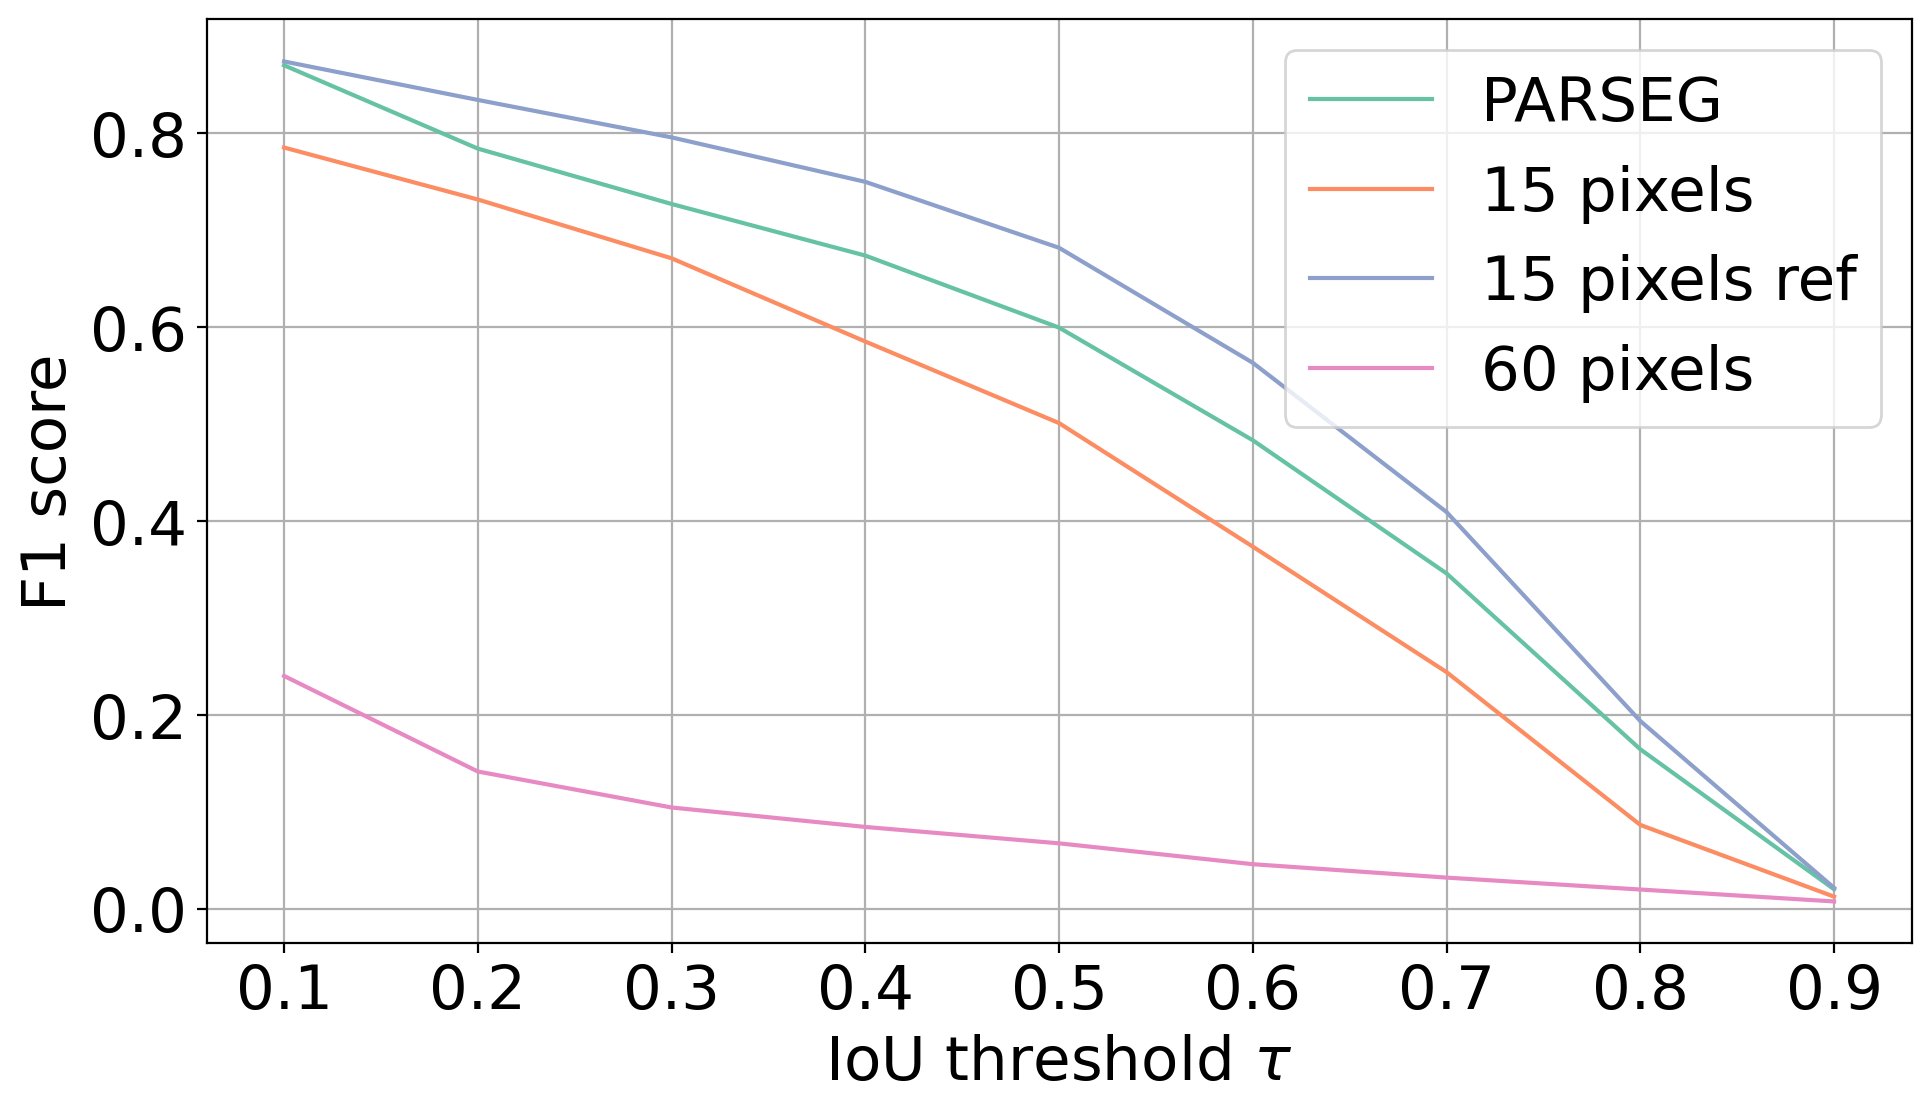

In [24]:
# # Create a custom style
# plt.style.use('dark_background')

# # Customize the rcParams for a transparent or black background with white text
# plt.rcParams.update({
#     'axes.facecolor': 'none',     # Background color of the plot area
#     'figure.facecolor': 'none',   # Background color around the plot
#     'axes.edgecolor': 'white',     # Color of the axes lines
#     'axes.labelcolor': 'white',    # Color of the axes labels
#     'xtick.color': 'white',        # Color of the x-tick labels
#     'ytick.color': 'white',        # Color of the y-tick labels
#     'text.color': 'white',         # Color of the text
#     'grid.color': 'gray',          # Color of the grid lines
# })

plt.style.use('default')

plt.rcParams.update({'font.size': 22})

plot_df = pd.DataFrame({
    'PARSEG': F1_combined,
#    'PARSEG auto': F1_auto,
    '15 pixels': F1_15_og,
   '15 pixels ref': F1_15,
    '60 pixels': F1_60,
    'Threshold': thresholds,
    
})

sns.set_palette("Set2")

# Reshape the DataFrame from wide to long format
df_melted = pd.melt(plot_df, id_vars=['Threshold'], var_name='F1 score', value_name='Value')

fig, ax = plt.subplots(figsize=(11, 6))

sns.lineplot(x='Threshold',data=df_melted, y='Value', hue='F1 score', ax=ax)

ax.set_xlabel(r'IoU threshold $\tau$')
ax.set_ylabel('F1 score')
ax.grid()
ax.legend()
    
plt.show()